# Signal Subgraph Screening

### ISSUES:
#### Looping through a generated tensor of tensors vs finding the correlation within the loop of creating the many tensors does not yield the same AUC values
#### Also RV and CCA are have higher AUC values than MGC and DCORR
#### Also the labels for SKLearn's ROC and AUC calculations have to be inverted for some reason in order for the fpr and tpr to be accurate

#  **Signal Subgraph Screening**
_________________________________________________________________


## As described in this [paper](https://arxiv.org/abs/1801.07683v1)

# Tutorial

## CLASSIFIER

In [ ]:
import numpy as np
def classifier_method(num_graphs, N, prob_tensor, percent_vec, ss_m_n, data, y_label):
    
    '''
    Classifies each graph in a dataset through Bayes plug-in classifier
    
    Parameters
    
    ----------
    
    num_graphs: the number of adjacency matrices in the dataset
    
    N: Length/width of the adjacency matrices in the tensor
    
    prob_tensor: tensor with the probability matrices for each graph type
    
    percent_vec: vector with the percentages of the total number of graphs that will be each type
    
    ss_m_n: Length/width of the estimated or actual signal subgraph
    
    data: tensor of adjacency matrices
    
    y_label: the ground truth labels of all the graphs in data
    
    Returns
    
    -------
    
    data: tensor of adjacency matrices
    y_label: the ground truth labels of all the graphs in data
    p_tensor: tensor with one matrix for each type of graph, where the matrices contain the probability 
    of a connection at each node
    '''
    
    vals = range(len(percent_vec))
    
    num = num_graphs * percent_vec
    
    ind = np.asarray([np.where(y_label == i)[0] for i in vals])
    
    data_subsets = np.asarray([data[j] for j in ind])

    sums = np.asarray([np.sum(a, 0) for a in data_subsets])
    
    P_hat_vec = np.asarray([np.true_divide(sums[b],num[b]) for b in range(len(num))])
    
    #Generate blank label vector
    label_estimate = np.zeros(num_graphs)
    
    for i in range(len(data)):
        label_estimate[i] = mat_likelihood(data[i], P_hat_vec, ss_m_n, percent_vec)

    return label_estimate

## CLASSIFIER HELPER METHOD

In [ ]:
import numpy as np
def mat_likelihood(A, P_hat, domain, pi):
    pi = np.log(pi)
    A_complement = 1 - A
    P_hat_complement = 1 - P_hat
    types_ = 0
    count = 1
    for i in range(len(P_hat)):
        intermediate = np.triu(np.multiply(np.power(P_hat[i], A), np.power(P_hat_complement[i], A_complement)))
        intermediate = intermediate[domain]
        intermediate = np.sum(np.log(intermediate[np.nonzero(intermediate)]))
        val = intermediate + pi[i]
        if i == 0:
            final = val
        elif val > final:
            final = val
            types_ = i
        else:
            continue
    
    return types_

## AVERAGE AUC FOR NON-ITERATIVE MGC

In [933]:
import time
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

data_100 = np.zeros((100, 100, 200, 200))

prob_tensor = np.zeros((2,2,2))
prob_tensor[0] = [[0.3, 0.2], [0.2, 0.3]]
prob_tensor[1] = [[0.4, 0.2], [0.2, 0.3]]
n = [20, 180]
percent_vec = np.asarray([0.50, 0.50])

auc_MGC = np.zeros(0)

start_time = time.time()
for i in range(100): 
    
    data, y_label, p_data = data_generator(100, 200, n, prob_tensor, percent_vec)
    
    ss_m_n_MGC, other_MGC = non_iterative_screen(data, y_label, 0, "mgc")
    
    tpr_MGC, fpr_MGC, threshold = metrics.roc_curve(ss_lab, other_MGC, pos_label = 0)
    
    auc_MGC = np.append(auc_MGC, metrics.auc(fpr_MGC,tpr_MGC))
    
    
    
    data_100[i] = data
    

    
print("--- %s seconds ---" % (time.time() - start_time))



print("Average MGC")
print(np.average(auc_MGC))

--- 770.2753098011017 seconds ---
Average MGC
0.8209611111111111


## AUC STANDARD ERROR FOR NONITERATIVE MGC

In [934]:
from scipy import stats
print("MGC Standard Error")
print(stats.sem(auc_MGC))

MGC Standard Error
0.005201684937383651


## AVERAGE AUC FOR ItMGC-0.05

In [995]:
import time
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from graspy.plot import heatmap
%matplotlib inline

data_100_ItMGC_005 = np.zeros((100, 100, 200, 200))

prob_tensor = np.zeros((2,2,2))
prob_tensor[0] = [[0.3, 0.2], [0.2, 0.3]]
prob_tensor[1] = [[0.4, 0.2], [0.2, 0.3]]
n = [20, 180]
percent_vec = np.asarray([0.50, 0.50])

auc_ItMGC_005 = np.zeros(0)

start_time = time.time()
for i in range(100): 
    
    data, y_label, p_data = data_generator(100, 200, n, prob_tensor, percent_vec)
    
    corvals_ItMGC_005 = iterative_screen(data, y_label, 20, 0.05, "mgc")
    
    tpr_ItMGC_005, fpr_ItMGC_005, threshold = metrics.roc_curve(ss_lab, corvals_ItMGC_005, pos_label = 0)
    
    auc_ItMGC_005 = np.append(auc_ItMGC_005, metrics.auc(fpr_ItMGC_005,tpr_ItMGC_005))
    
    data_100_ItMGC_005[i] = data
    

    
print("--- %s seconds ---" % (time.time() - start_time))



print("ItMGC-0.05 Average")
print(np.average(auc_ItMGC_005))

--- 19425.051758766174 seconds ---
ItMGC-0.50
0.8479305555555555


## AUC STANDARD ERROR FOR ItMGC-0.05

In [996]:
from scipy import stats
print("ItMGC-0.05 Standard Error")
print(stats.sem(auc_ItMGC_005))

ItMGC-0.05 Standard Error
0.007112023360353524


## AVERAGE AUC FOR ItMGC-0.50

In [1007]:
import time
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from graspy.plot import heatmap
%matplotlib inline


data_100_ItMGC_05 = np.zeros((100, 100, 200, 200))

prob_tensor = np.zeros((2,2,2))
prob_tensor[0] = [[0.3, 0.2], [0.2, 0.3]]
prob_tensor[1] = [[0.4, 0.2], [0.2, 0.3]]
n = [20, 180]
percent_vec = np.asarray([0.50, 0.50])

auc_ItMGC_05 = np.zeros(0)

start_time = time.time()
for i in range(100): 
    
    data, y_label, p_data = data_generator(100, 200, n, prob_tensor, percent_vec)
    
    corvals_ItMGC_05 = iterative_screen(data, y_label, 20, 0.50, "mgc")
    
    tpr_ItMGC_05, fpr_ItMGC_05, threshold = metrics.roc_curve(ss_lab, corvals_ItMGC_05, pos_label = 0)
    
    auc_ItMGC_05 = np.append(auc_ItMGC_05, metrics.auc(fpr_ItMGC_05,tpr_ItMGC_05))
    
    data_100_ItMGC_05[i] = data

    
print("--- %s seconds ---" % (time.time() - start_time))



print("ItMGC-0.50 Average")
print(np.average(auc_ItMGC_05))

--- 1997.1234061717987 seconds ---
ItMGC-0.50 Average
0.8417861111111111


## AUC STANDARD ERROR FOR ItMGC-0.50

In [1001]:
from scipy import stats
print("ItMGC-0.50 Standard Error")
print(stats.sem(auc_ItMGC_05))

ItMGC-0.50 Standard Error
0.006806269866770942


## REPRODUCING FIGURES

MGC:
0.8308333333333333
ItMGC-0.05:
0.8463888888888889


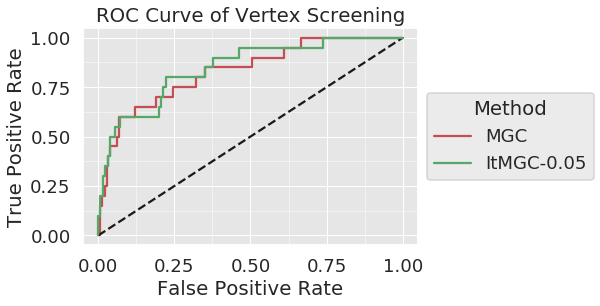

In [1005]:
import seaborn as sns
import matplotlib as mpl
sns.set()
sns.set_context("talk", font_scale=1.10)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
fig, ax = plt.subplots(1, 1)
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)
ax.set_xticks([0, 0.125, 0.25, 0.375, 0.50, 0.625, 0.750, 0.875, 1.0], minor=True)
ax.set_yticks([0, 0.125, 0.25, 0.375, 0.50, 0.625, 0.750, 0.875, 1.0], minor=True)
plt.step(fpr_MGC, tpr_MGC, 'r', label = "MGC")
plt.title("ROC Curve of Vertex Screening")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.yticks(np.arange(0, 1.25, 0.25))
plt.xticks(np.arange(0, 1.25, 0.25))
plt.plot([0, 1], [0, 1],'k--')
print("MGC:")
print(metrics.auc(fpr_MGC, tpr_MGC))

print("ItMGC-0.05:")
plt.figure
plt.step(fpr_ItMGC_005, tpr_ItMGC_005, 'g', label = "ItMGC-0.05")
print(metrics.auc(fpr_ItMGC_005, tpr_ItMGC_005))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title = "Method")

In [1235]:
import plotly.graph_objects as go

print("Paper Results")

fig = go.Figure(data=[go.Table(header=dict(values=['Method', 'AUC', 'Time (sec)']),
                 cells=dict(values=[['ItMGC-0.05', 'ItMGC-0.50', 'MGC'], ['0.8620 (0.0116)', '0.8425 (0.0120)', '0.8241 (0.0057)'], ['856.37 (14.45)', '110.23 (7.19)', '33.39 (1.90)']]))
                     ])
fig.show()

print("My Results")

fig2 = go.Figure(data=[go.Table(header=dict(values=['Method', 'AUC', 'Time (sec)']),
                 cells=dict(values=[['ItMGC-0.05', 'ItMGC-0.50', 'MGC'], ['0.8479 (0.0071)', '0.8418 (0.0068)', '0.8210 (0.0052)'], ['194.25', '19.97', '7.70']]))
                     ])
fig2.show()

Paper Results


My Results


In [1029]:
import seaborn as sns
import matplotlib as mpl

prob_tensor = np.zeros((2,2,2))
prob_tensor[0] = [[0.3, 0.2], [0.2, 0.3]]
prob_tensor[1] = [[0.4, 0.2], [0.2, 0.3]]
n = [20, 180]
percent_vec = np.asarray([0.50, 0.50])

list_fpr_MGC = []
list_fpr_ItMGC = []

data_75, y_label_75, p_data_75 = data_generator(75, 200, n, prob_tensor, percent_vec)

SS, cors_MGC = non_iterative_screen(data_75, y_label_75, 0, "mgc")
cors_ItMGC_005 = iterative_screen(data_75, y_label_75, 20, 0.05, "mgc")





data_150, y_label_150, p_data_150 = data_generator(150, 200, n, prob_tensor, percent_vec)


data_225, y_label_225, p_data_225 = data_generator(225, 200, n, prob_tensor, percent_vec)
data_300, y_label_300, p_data_300 = data_generator(300, 200, n, prob_tensor, percent_vec)



sns.set()
sns.set_context("talk", font_scale=1.10)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
fig, ax = plt.subplots(1, 1)
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)
ax.set_xticks([75, 150, 225, 300], minor=True)
ax.set_yticks([0, 0.2, 0.4, 0.6], minor=True)
plt.title("Vertex False Positive Rate")
plt.ylabel("Rate")
plt.xlabel("Number of Graphs")
plt.yticks(np.arange(0, 0.8, 0.2))
plt.xticks(np.arange(75, 375, 75))

plt.figure

#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title = "Method")

(2, 200, 200)


KeyboardInterrupt: 